## Machine Learning Classifaction
1. Support Vector Machine SVM

One of the advantages of sVM is that it is very effective in high dimensional spaces. 

We will not use PCA on the training sets to reduce the number of dimensions for SVM.

In [1]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import cross_val_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#The Background Dataset
background = pd.read_csv('./datasets/training/background-giants.csv')

background_id = background[['objID', 'ra', 'dec']]

#Dropping the irrelevant features for training SVM model.
background = background.drop(['objID','objID1','ra','dec'], axis=1)
background.head()

,psfMag_u0,psfMag_g0,psfMag_r0,psfMag_i0,psfMag_z0,fiberMag_u0,fiberMag_g0,fiberMag_r0,fiberMag_i0,fiberMag_z0,...,fracDeV_u,fracDeV_g,fracDeV_r,fracDeV_i,fracDeV_z,dered_u,dered_g,dered_r,dered_i,dered_z
0,21.08928,19.37086,18.25864,17.81117,17.51476,21.25800,19.36015,18.24822,17.80149,17.45830,...,1.000000,1.000000,1.000000,1.000000,1.000000,20.13362,18.32410,17.19614,16.74197,16.40898
1,21.41094,19.66853,19.04671,18.49730,18.12082,21.32957,19.64395,18.69971,18.21872,17.81517,...,0.000000,0.048899,0.111197,0.102860,0.200284,18.94811,17.26758,16.39990,15.94577,15.60334
2,21.27979,19.46498,18.33810,17.92343,17.63418,21.25036,19.44884,18.34415,17.88955,17.55409,...,1.000000,1.000000,1.000000,1.000000,1.000000,20.15441,18.22609,17.11155,16.65807,16.33635
3,20.79575,18.89698,17.82768,17.38629,17.21747,20.79277,18.79881,17.79642,17.37555,17.02053,...,1.000000,0.930281,0.932025,0.997685,1.000000,19.56097,17.58059,16.57519,16.14223,15.82258
4,19.69155,17.76127,16.98154,16.55225,16.24577,19.77281,17.82529,16.89516,16.47335,16.13554,...,0.951221,0.916555,0.941605,0.954829,0.975430,18.35271,16.36183,15.47458,15.03607,14.70395


In [3]:
#The Foreground Dataset
foreground = pd.read_csv('./datasets/training/foreground-dwarfs.csv')

foreground_id = foreground[['objID', 'ra', 'dec']]

#Droping the unuseful objID that comes with CrossID
foreground = foreground.drop(['objID','objID1','ra','dec'], axis=1)
foreground.head()

,psfMag_u0,psfMag_g0,psfMag_r0,psfMag_i0,psfMag_z0,fiberMag_u0,fiberMag_g0,fiberMag_r0,fiberMag_i0,fiberMag_z0,...,fracDeV_u,fracDeV_g,fracDeV_r,fracDeV_i,fracDeV_z,dered_u,dered_g,dered_r,dered_i,dered_z
0,20.68459,20.32490,19.90491,19.65816,19.58863,20.93056,19.84648,19.39435,19.13173,18.93974,...,0.000000,0.000000,0.000000,0.000000,0.024766,17.14250,16.04856,15.63828,15.42416,15.29288
1,20.38590,18.79545,18.40734,18.01583,17.85035,20.31682,18.76537,18.05824,17.72758,17.45851,...,0.132033,0.252313,0.271305,0.262290,0.388589,18.42509,16.79932,16.11763,15.77143,15.49772
2,20.37486,19.15429,18.46381,18.16368,18.04567,20.36893,18.84602,18.14171,17.79829,17.57360,...,0.059789,0.199078,0.165721,0.215467,0.192362,18.37703,16.79943,16.09405,15.74896,15.51344
3,20.10566,18.50956,17.90357,17.60673,17.37036,20.09557,18.56411,17.81530,17.47781,17.24816,...,0.863581,0.726548,0.861712,0.876894,0.829082,17.90406,16.35933,15.61268,15.26653,15.02099
4,20.55464,18.93523,18.13289,17.79406,17.84563,20.42518,18.61701,17.89809,17.54489,17.28442,...,0.243175,0.357629,0.358013,0.392165,0.397820,18.33514,16.66942,15.94401,15.56867,15.34149


In [4]:
# Keep concatenated id when for later merge
galaxies_id = pd.concat([foreground_id,background_id])
galaxies_id.head()

,objID,ra,dec
0,1237680311772250464,16.765005,32.389555
1,1237680315521237319,16.792826,32.346872
2,1237680311772250198,16.685466,32.418586
3,1237680315521302864,16.966691,32.256108
4,1237680311772381486,17.066149,32.499011


In [5]:
#Adding the column that labels these as the background
#In this case the label for background is 0 and 
#foreground will be 1
background['label'] = 0
foreground['label'] = 1

In [6]:
# The foreground and background sets now have to be concated together and have the label column removed as a seperate 
# array to perform SVM.
galaxies = pd.concat([foreground,background])
galaxies.head()

,psfMag_u0,psfMag_g0,psfMag_r0,psfMag_i0,psfMag_z0,fiberMag_u0,fiberMag_g0,fiberMag_r0,fiberMag_i0,fiberMag_z0,...,fracDeV_g,fracDeV_r,fracDeV_i,fracDeV_z,dered_u,dered_g,dered_r,dered_i,dered_z,label
0,20.68459,20.32490,19.90491,19.65816,19.58863,20.93056,19.84648,19.39435,19.13173,18.93974,...,0.000000,0.000000,0.000000,0.024766,17.14250,16.04856,15.63828,15.42416,15.29288,1
1,20.38590,18.79545,18.40734,18.01583,17.85035,20.31682,18.76537,18.05824,17.72758,17.45851,...,0.252313,0.271305,0.262290,0.388589,18.42509,16.79932,16.11763,15.77143,15.49772,1
2,20.37486,19.15429,18.46381,18.16368,18.04567,20.36893,18.84602,18.14171,17.79829,17.57360,...,0.199078,0.165721,0.215467,0.192362,18.37703,16.79943,16.09405,15.74896,15.51344,1
3,20.10566,18.50956,17.90357,17.60673,17.37036,20.09557,18.56411,17.81530,17.47781,17.24816,...,0.726548,0.861712,0.876894,0.829082,17.90406,16.35933,15.61268,15.26653,15.02099,1
4,20.55464,18.93523,18.13289,17.79406,17.84563,20.42518,18.61701,17.89809,17.54489,17.28442,...,0.357629,0.358013,0.392165,0.397820,18.33514,16.66942,15.94401,15.56867,15.34149,1


https://towardsdatascience.com/feature-selection-techniques-in-machine-learning-with-python-f24e7da3f36e

We need to do some feature engineering before building a model:
1. Univariate Selection
2. Feature Importance
3. Correlation Matrix with Heatmap

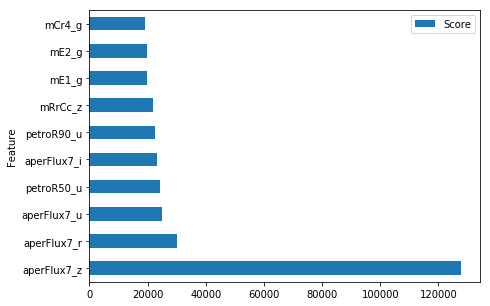

In [7]:
# Univariate selection can be used to select those features that have the strongest relationship with the output 
# variable.
X = galaxies.drop(['label'], axis=1) # Independent columns
X = X.abs() # Removing negative values
y = galaxies['label'] # Target column, galaxy type

# Applying SelectKBest to extract top 10 best features
best_features = SelectKBest(score_func=chi2, k=10)
fit = best_features.fit(X, y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
features_scores = pd.concat([dfcolumns, dfscores], axis=1) # Concatenate dataframes for better visualization
features_scores.columns = ['Feature', 'Score'] # Naming dataframe columns
features_scores.nlargest(10, 'Score').plot(x='Feature', y='Score', kind='barh', figsize=(7, 5))
plt.show()
# print(features_scores.nlargest(10, 'Score')) # Print 10 best features

/Users/danrachou/Documents/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


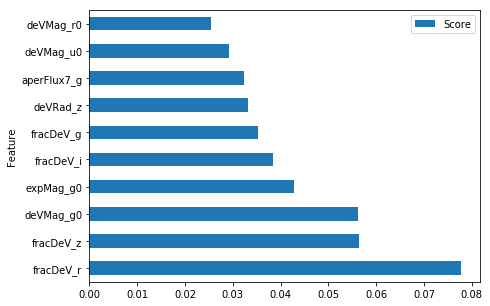

In [8]:
# Feature importance gives you a score for each feature of your data, the higher the score more important or relevant
# is the feature towards your output variable.
X = galaxies.drop(['label'], axis=1) # Independent columns
y = galaxies['label'] # Target column, galaxy type
model = ExtraTreesClassifier()
model.fit(X, y)

# Plot graph of feature importances to for better visualization
# feature_importances_ is a inbuilt class
#feat_importances = pd.Series(model.feature_importances_, index=X.columns)
dfscores = pd.DataFrame(model.feature_importances_)
dfcolumns = pd.DataFrame(X.columns)
feat_importances = pd.concat([dfcolumns, dfscores], axis=1)
feat_importances.columns = ['Feature', 'Score']
feat_importances.nlargest(10, 'Score').plot(x='Feature', y='Score', kind='barh', figsize=(7, 5))
plt.show()

In [9]:
# Features for heatmap:
features = pd.concat([features_scores.nlargest(10, 'Score'), feat_importances.nlargest(10, 'Score')])
features = features.sort_values('Feature')
features['Feature']

121    aperFlux7_g
123    aperFlux7_i
122    aperFlux7_r
120    aperFlux7_u
124    aperFlux7_z
96       deVMag_g0
97       deVMag_r0
95       deVMag_u0
89        deVRad_z
111      expMag_g0
126      fracDeV_g
128      fracDeV_i
127      fracDeV_r
129      fracDeV_z
61          mCr4_g
46           mE1_g
51           mE2_g
59         mRrCc_z
25      petroR50_u
30      petroR90_u
Name: Feature, dtype: object

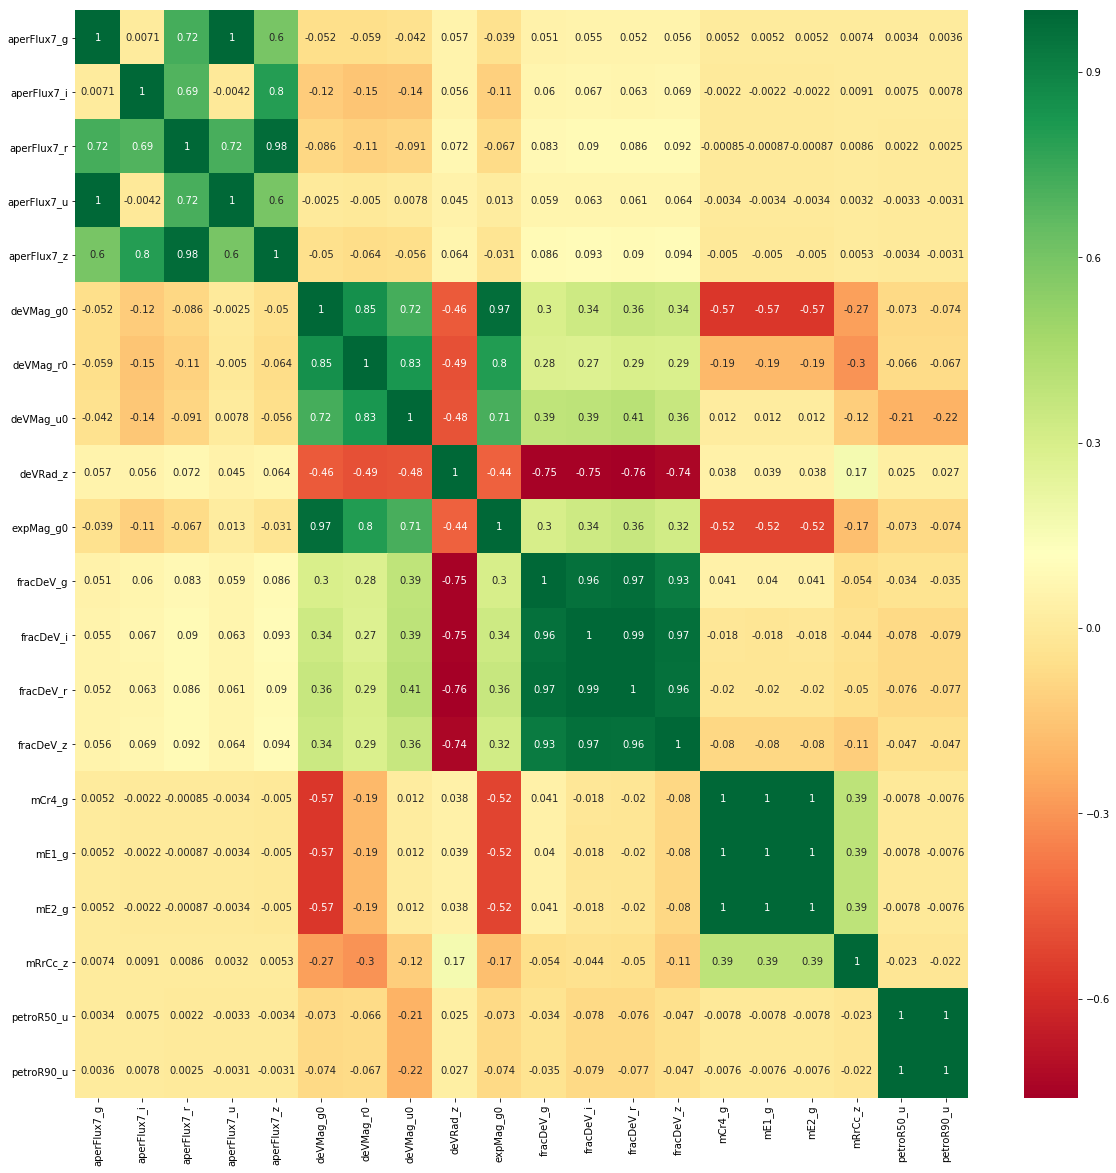

In [10]:
# Correlation Matrix with Heatmap
corrmat = galaxies[features['Feature']].corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
g=sns.heatmap(galaxies[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [11]:
# Parameter tuning using GridSearchCV
def svc_param_selection(X, y):
    Cs = [0.001, 0.01, 0.1, 1, 10]
    gammas = [0.001, 0.01, 0.1, 1, 10]
    nfolds = 5
    param_grid = {'C': Cs, 'gamma': gammas}
    grid_search = GridSearchCV(svm.SVC(kernel='rbf'), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    return grid_search.best_params_

### All Features
Training ML model on all features of the dataset.

In [12]:
#The two seperate array used in SVM to construct a predicting model
X = galaxies.drop('label',1)
y = galaxies['label']

In [13]:
# Cross validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train.shape, y_train.shape

((470, 135), (470,))

In [14]:
X_test.shape, y_test.shape

((118, 135), (118,))

In [15]:
svc_param_selection(X, y)

{'C': 1, 'gamma': 0.001}

In [16]:
# Using the default kernel type which is a Gaussian
clf = svm.SVC(C=1, gamma=0.001)
# Fitting the model and it can now be used to predict labels if we feed it a dataframe with the same columns
clf.fit(X_train, y_train)
scores = cross_val_score(clf, X_test, y_test, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.80 (+/- 0.14)


In [17]:
# Using sigmoid kernel
sigmoidModel = svm.SVC(C=1, gamma=0.001, kernel='sigmoid')
sigmoidModel.fit(X_train, y_train)
scores = cross_val_score(sigmoidModel, X_test, y_test, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.47 (+/- 0.27)


In [18]:
# Using polynomial kernel of different degrees
polyModel = svm.SVC(C=1, gamma=0.001, kernel='poly', degree=1)
polyModel.fit(X_train, y_train)
scores = cross_val_score(polyModel, X_test, y_test, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.90 (+/- 0.04)


In [19]:
polyModel = svm.SVC(C=1, gamma=0.001, kernel='poly', degree=2)
polyModel.fit(X_train, y_train)
scores = cross_val_score(polyModel, X_test, y_test, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.87 (+/- 0.10)


In [20]:
#polyModel = svm.SVC(C=1, gamma=0.001, kernel='poly', degree=3)
#polyModel.fit(X_train, y_train)
#scores = cross_val_score(polyModel, X_test, y_test, cv=5)
#print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

### 10 Best Features and 10 Most Important Features
Training the model on 10 of the best scoring features and 10 of most important features.

In [21]:
X = galaxies[features['Feature']]
y = galaxies['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train.shape, y_train.shape

((470, 20), (470,))

In [22]:
X_test.shape, y_test.shape

((118, 20), (118,))

In [23]:
svc_param_selection(X, y)

{'C': 1, 'gamma': 0.001}

In [24]:
clf = svm.SVC(C=1, gamma=0.001)
clf.fit(X_train, y_train)
scores = cross_val_score(clf, X_test, y_test, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.89 (+/- 0.09)


We see accuracy improvement of 0.03% of the Gaussian kernel after some feature engineering.

In [25]:
# Using sigmoid kernel
sigmoidModel = svm.SVC(C=1, gamma=0.001, kernel='sigmoid')
sigmoidModel.fit(X_train, y_train)
scores = cross_val_score(sigmoidModel, X_test, y_test, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.58 (+/- 0.23)


In [26]:
# Using polynomial kernel of different degrees
polyModel = svm.SVC(C=1, gamma=0.001, kernel='poly', degree=1)
polyModel.fit(X_train, y_train)
scores = cross_val_score(polyModel, X_test, y_test, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.91 (+/- 0.07)


In [27]:
# Model we think have the best overall performance.
final_model = polyModel

In [28]:
polyModel = svm.SVC(C=1, gamma=0.001, kernel='poly', degree=2)
polyModel.fit(X_train, y_train)
scores = cross_val_score(polyModel, X_test, y_test, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.88 (+/- 0.09)


In [29]:
# Takes a really long time...
#polyModel = svm.SVC(C=1, gamma=0.001, kernel='poly', degree=3)
#polyModel.fit(X_train, y_train)
#scores = cross_val_score(polyModel, X_test, y_test, cv=5)
#print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

### 10 Best Features
Training the ML model on the 5 best features gives the same accuracy score as training the moddel on the 10 best features.

In [30]:
X = galaxies[features_scores.nlargest(10, 'Score')['Feature']]
y = galaxies['label']

In [31]:
# Cross validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train.shape, y_train.shape

((470, 10), (470,))

In [32]:
X_test.shape, y_test.shape

((118, 10), (118,))

In [33]:
svc_param_selection(X, y)

{'C': 1, 'gamma': 0.001}

In [34]:
clf = svm.SVC(C=1, gamma=0.001)
clf.fit(X_train, y_train)
scores = cross_val_score(clf, X_test, y_test, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.88 (+/- 0.08)


In [35]:
# Using sigmoid kernel
sigmoidModel = svm.SVC(C=1, gamma=0.001, kernel='sigmoid')
sigmoidModel.fit(X_train, y_train)
scores = cross_val_score(sigmoidModel, X_test, y_test, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.58 (+/- 0.23)


In [36]:
# Using polynomial kernel of different degrees
polyModel = svm.SVC(C=1, gamma=0.001, kernel='poly', degree=1)
polyModel.fit(X_train, y_train)
scores = cross_val_score(polyModel, X_test, y_test, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.87 (+/- 0.12)


In [37]:
polyModel = svm.SVC(C=1, gamma=0.001, kernel='poly', degree=2)
polyModel.fit(X_train, y_train)
scores = cross_val_score(polyModel, X_test, y_test, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.87 (+/- 0.12)


### 10 Most Important Features

In [38]:
X = galaxies[feat_importances.nlargest(10, 'Score')['Feature']]
y = galaxies['label']

In [39]:
# Cross validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train.shape, y_train.shape

((470, 10), (470,))

In [40]:
X_test.shape, y_test.shape

((118, 10), (118,))

In [41]:
svc_param_selection(X, y)

{'C': 10, 'gamma': 0.001}

In [42]:
clf = svm.SVC(C=10, gamma=0.001)
clf.fit(X_train, y_train)
scores = cross_val_score(clf, X_test, y_test, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.91 (+/- 0.10)


In [43]:
# Using sigmoid kernel
sigmoidModel = svm.SVC(C=10, gamma=0.001, kernel='sigmoid')
sigmoidModel.fit(X_train, y_train)
scores = cross_val_score(sigmoidModel, X_test, y_test, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.70 (+/- 0.02)


In [44]:
# Using polynomial kernel of different degrees
polyModel = svm.SVC(C=10, gamma=0.001, kernel='poly', degree=1)
polyModel.fit(X_train, y_train)
scores = cross_val_score(polyModel, X_test, y_test, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.87 (+/- 0.10)


In [45]:
polyModel = svm.SVC(C=10, gamma=0.001, kernel='poly', degree=2)
polyModel.fit(X_train, y_train)
scores = cross_val_score(polyModel, X_test, y_test, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.90 (+/- 0.09)


### 20 Most Important Features

In [46]:
X = galaxies[feat_importances.nlargest(20, 'Score')['Feature']]
y = galaxies['label']

In [47]:
# Cross validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train.shape, y_train.shape

((470, 20), (470,))

In [48]:
X_test.shape, y_test.shape

((118, 20), (118,))

In [49]:
svc_param_selection(X, y)

{'C': 10, 'gamma': 0.001}

In [50]:
clf = svm.SVC(C=10, gamma=0.01)
clf.fit(X_train, y_train)
scores = cross_val_score(clf, X_test, y_test, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.87 (+/- 0.13)


In [51]:
# Using sigmoid kernel
sigmoidModel = svm.SVC(C=10, gamma=0.01, kernel='sigmoid')
sigmoidModel.fit(X_train, y_train)
scores = cross_val_score(sigmoidModel, X_test, y_test, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.70 (+/- 0.02)


In [52]:
# Using polynomial kernel of different degrees
polyModel = svm.SVC(C=10, gamma=0.01, kernel='poly', degree=1)
polyModel.fit(X_train, y_train)
scores = cross_val_score(polyModel, X_test, y_test, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.91 (+/- 0.09)


In [53]:
polyModel = svm.SVC(C=10, gamma=0.01, kernel='poly', degree=2)
polyModel.fit(X_train, y_train)
scores = cross_val_score(polyModel, X_test, y_test, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.88 (+/- 0.13)


### Perseus Cluster
* Merge galaxy_id dataframe with galaxy dataframe. 
* Then import dataset of Perseus galaxies in the magnitude range of 15.5 to 16.5. 
* Store object id and coordinates in a seperate dataset. 
* Pick the model with the best accuracy and feed it the Perseus cluster dataset. 
* Merge IDs dataset, the dataset to you feeded the ML model and the ML model output. 
* Compare the result with known dwarfs from Persues by counting the duplicates. 
* Generate thumbnail search dataset for visual check of the dataset.

In [54]:
perseus = pd.read_csv('./datasets/test/perseus-cluster.csv')

perseus_id = perseus[['objID', 'ra', 'dec']]
perseus_id.head()

,objID,ra,dec
0,1237660977971856019,50.390209,41.300929
1,1237661055281857673,49.979898,41.172632
2,1237661055282053713,50.510522,41.045720
3,1237661055818334676,49.260335,42.102344
4,1237661055818727819,50.292048,41.659046


In [55]:
perseus_data = perseus[features['Feature']]
perseus_data.head()

,aperFlux7_g,aperFlux7_i,aperFlux7_r,aperFlux7_u,aperFlux7_z,deVMag_g0,deVMag_r0,deVMag_u0,deVRad_z,expMag_g0,fracDeV_g,fracDeV_i,fracDeV_r,fracDeV_z,mCr4_g,mE1_g,mE2_g,mRrCc_z,petroR50_u,petroR90_u
0,63.019500,221.4617,146.91920,12.083440,302.014200,16.95593,16.18266,18.49820,6.504540,17.39497,0.393564,0.499259,0.457874,0.441424,2.391119,0.139064,-0.048238,52.24176,3.290705,7.020861
1,108.188200,342.8437,236.68410,19.780940,449.937200,16.45368,15.76472,18.14619,8.437828,16.86645,0.209844,0.171316,0.195266,0.137794,2.285739,0.630774,0.102966,52.92003,3.089519,7.935118
2,40.817040,199.7382,79.51788,0.000037,0.000155,16.33953,15.74794,24.03824,0.032802,16.65485,0.000000,0.000000,0.000000,0.000000,0.929227,0.120823,-0.041005,-9999.00000,-9999.000000,-9999.000000
3,0.000018,872.9240,96.24981,0.000045,0.000158,24.63999,15.74993,24.05051,3.923913,24.66638,0.000000,0.244874,0.255051,0.000000,-9999.000000,-9999.000000,-9999.000000,-9999.00000,3.924036,4.296985
4,178.126000,351.8015,252.50550,0.000045,0.000157,15.38810,14.98088,22.86328,0.036949,15.97026,0.164477,0.233670,0.046738,0.000000,2.302466,-0.123132,0.159536,-9999.00000,24.142770,24.722420


In [56]:
final_model

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=1, gamma=0.001, kernel='poly',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [62]:
results = final_model.predict(perseus_data)

In [63]:
print('Number of foregrounds : {}'.format(np.count_nonzero(results == 1)))

Number of foregrounds : 217


In [64]:
print(results)

[0 1 0 0 1 1 1 0 0 1 1 1 1 0 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 0 1 0 0 1 1 0 1
 1 1 1 0 1 1 0 0 0 1 0 1 1 1 1 0 1 1 0 1 0 1 1 0 0 0 0 1 0 1 0 0 0 1 0 1 1
 1 0 0 0 0 1 1 0 0 1 1 0 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1 1 1 0 1 1 1 1 0 1 0
 1 0 1 1 1 1 0 0 0 0 1 1 0 1 1 1 0 0 0 1 1 1 0 1 1 0 1 1 0 0 0 0 1 1 0 1 1
 0 1 1 0 1 1 1 0 1 1 0 0 1 1 0 1 1 1 0 1 1 0 0 1 1 1 1 0 0 0 0 0 1 1 1 1 1
 1 0 0 1 1 0 0 0 1 0 1 1 0 1 0 1 1 1 1 1 0 0 1 1 1 1 1 1 0 0 1 1 0 1 1 1 1
 0 0 1 0 1 1 1 0 1 1 0 0 0 1 0 0 1 1 0 0 1 0 0 1 1 1 1 1 1 0 1 1 1 0 1 1 1
 0 1 1 1 0 0 0 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 0 1 0 1 1 1 0 0 1 1 1 1 0 1 1
 0 0 0 0 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 0 1 1 1 1 1 0 0 0 0 1
 1 0 0 1 0 1 1 1 0 1 1 0 1 0 1 0 1 0 0 0 0 0 1 0 0 1 0 1 1 0 0 0 1 1 1 0]


In [73]:
perseus_id['label'] = results
perseus_id.head()

/Users/danrachou/Documents/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,objID,ra,dec,label
0,1237660977971856019,50.390209,41.300929,0
1,1237661055281857673,49.979898,41.172632,1
2,1237661055282053713,50.510522,41.045720,0
3,1237661055818334676,49.260335,42.102344,0
4,1237661055818727819,50.292048,41.659046,1


In [99]:
ml_dwarfs = perseus_id.loc[perseus_id['label'] == 1]
ml_dwarfs[['objID', 'ra', 'dec']].head()

,objID,ra,dec
1,1237661055281857673,49.979898,41.172632
4,1237661055818727819,50.292048,41.659046
5,1237661055818793237,50.508234,41.644696
6,1237660977971528033,49.694482,41.772157
9,1237661055281856828,50.029055,41.267249


In [100]:
known_dwarfs = pd.read_csv('./datasets/complete/perseus.csv')
known_dwarfs[['objID', 'ra', 'dec']].head()

,objID,ra,dec
0,1237661059574399032,50.021608,41.508698
1,1237661059574399032,50.021608,41.508698
2,1237661059574399003,49.996059,41.479603
3,1237661059574334072,49.932572,41.456982
4,1237661059574334104,49.935962,41.446462


In [104]:
ml_dwarfs.shape[0] # Number of dwarfs classified from ML algorithm

217

In [105]:
known_dwarfs.shape[0] # Number of known dwarfs from Perseus cluster

183

In [106]:
ml_dwarfs.shape[0] - known_dwarfs.shape[0] # Number of dwarfs that should be left after removing duplicates

34

In [111]:
total = pd.concat([known_dwarfs[['objID', 'ra', 'dec']],known_dwarfs[['objID', 'ra', 'dec']]], axis=0)
total.shape[0]

366

In [112]:
total.drop_duplicates().shape[0]

179

In [ ]:
ml_dwarfs['objID', 'ra' 'dec'].to_csv(r'./datasets/thumbnail-search/ml-dwarfs', sep=' ', index=False)

In [113]:
#We now grab the test data which is the Perseus cluster csv file retrieved from SDSS
#base_test = pd.read_csv('./datasets/test/perseus.csv')

#Strip all the unusefull data and format it to be usefull in SDSS CrossID
#cross_id_test = base_test

#Export formated file to be used in SDSS CrossID
#cross_id_test.to_csv(r'./machine-learning-sets/testData_crossID.csv', index=False)

#After doing CrossID, importing the Testing Dataset
#test_Data = pd.read_csv('./machine-learning-sets/testData_crossID.csv')

#Droping the unuseful objID that comes with CrossID
#test_Data = test_Data.drop(['ra','dec'], axis=1)

#test_Data.head()

In [58]:
#Time for the predict, remember that 1 means foreground and 0 means background
#clf = model.predict(test_Data)
#scores = cross_val_score(clf, iris.data, iris.target, cv=5)
#print('Number of foregrounds with gauss kernel: {}'.format(np.count_nonzero(clf == 1)))
#print('Number of backgrounds with gauss kernel: {}'.format(np.count_nonzero(clf == 0)))

In [59]:
#Iteration of the model using the sigmoid kernel rather than the rbf gaussian one
#sigmoidModel = svm.SVC(gamma='auto', kernel='sigmoid')
#sigmoidModel.fit(samples,labels)
#sigResults = sigmoidModel.predict(test_Data)
#print('Number of foregrounds with sigmoid kernel: {}'.format(np.count_nonzero(sigResults == 1)))
#print('Number of backgrounds with sigmoid kernel: {}'.format(np.count_nonzero(sigResults == 0)))

In [60]:
#Iteration of the model using a polynomial kernel of degree, d
#d = 5
#for n in range(1,d+1):
#    polyModel = svm.SVC(gamma='auto', kernel='poly', degree=n)
#    polyModel.fit(samples,labels)
#    polyResults = polyModel.predict(test_Data)
#    print('Number of foregrounds with poly kernel at degree {}: {}'.format(n,np.count_nonzero(polyResults == 1)))
#    print('Number of backgrounds with poly kernel degree {}: {}'.format(n,np.count_nonzero(polyResults == 0)))
#    print('----------------------------------------------------------------------------------------------------')

In [61]:
#print(polyResults)